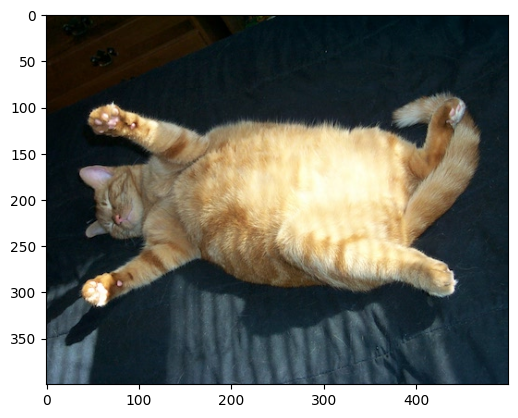

In [2]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize
img=d2l.Image.open('../img/cat1.jpg')
# img=d2l.Image.open('/kaggle/working/cat1.jpg')
d2l.plt.imshow(img);

翻转和裁剪

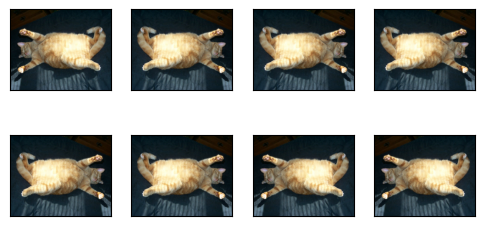

In [3]:
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
    """在输入图像img上多次运行图像增广方法aug并显示所有结果"""
    Y=[aug(img) for _ in range(num_rows*num_cols)]
    d2l.show_images(Y,num_rows,num_cols,scale=scale)

apply(img,torchvision.transforms.RandomHorizontalFlip()) # 使图像各有50%的几率向左或向右翻转

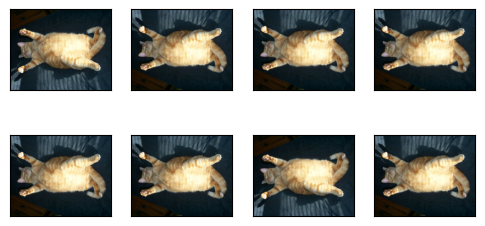

In [4]:
apply(img,torchvision.transforms.RandomVerticalFlip())

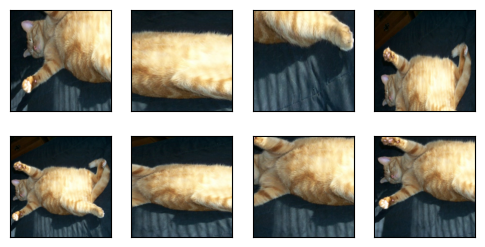

In [5]:
# 随机裁剪一个面积为原始面积10%到100%的区域,区域的宽高比从0.5～2之间随机取值,之后宽高都被缩放到200像素
shape_aug=torchvision.transforms.RandomResizedCrop(
    (200,200),scale=(0.1,1),ratio=(0.5,2)) 
apply(img,shape_aug)

改变颜色

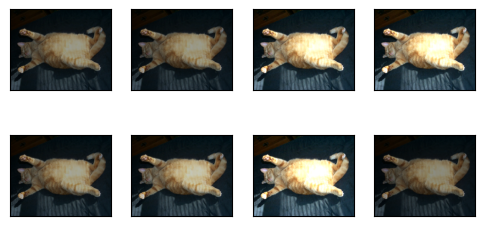

In [6]:
apply(img,torchvision.transforms.ColorJitter(
    brightness=0.5,contrast=0,saturation=0,hue=0))  # 亮度随机在原始图像亮度的50%到150%之间取值

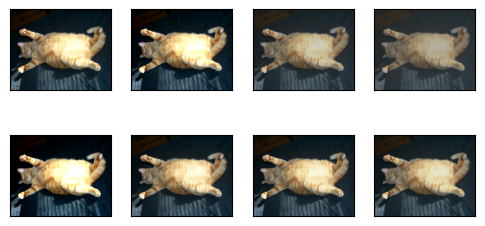

In [7]:
apply(img,torchvision.transforms.ColorJitter(
    brightness=0,contrast=0.5,saturation=0,hue=0))  # 对比度

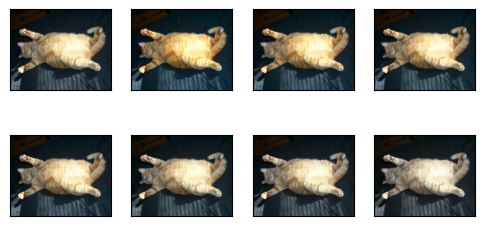

In [8]:
apply(img,torchvision.transforms.ColorJitter(
    brightness=0,contrast=0,saturation=0.5,hue=0))  # 饱和度

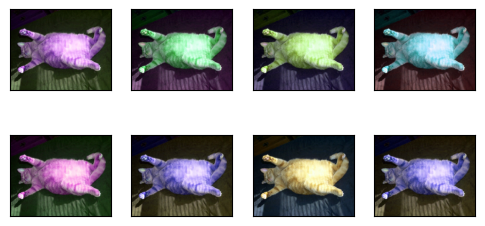

In [9]:
apply(img,torchvision.transforms.ColorJitter(
    brightness=0,contrast=0,saturation=0,hue=0.5))  # 色调

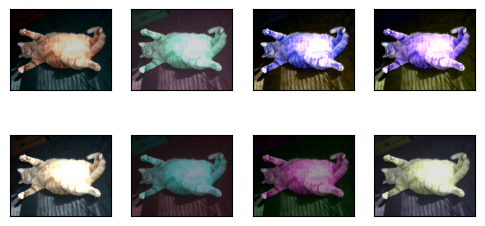

In [10]:
color_aug=torchvision.transforms.ColorJitter(
    brightness=0.5,contrast=0.5,saturation=0.5,hue=0.5)
apply(img,color_aug)

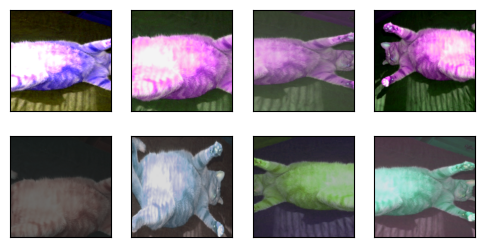

In [11]:
augs=torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    shape_aug,color_aug
])
apply(img,augs)

使用图像增广进行训练

Files already downloaded and verified


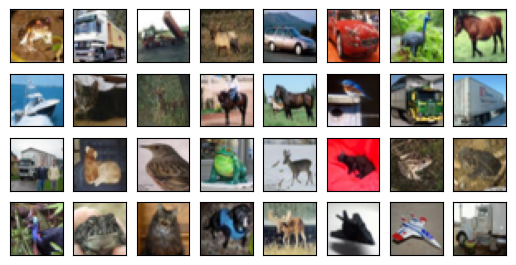

In [12]:
all_images=torchvision.datasets.CIFAR10(train=True,root="../data",download=True)
d2l.show_images([all_images[i][0] for i in range(32)],4,8,scale=0.8);

In [13]:
train_augs=torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

test_augs=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

def load_cifar10(is_train,augs,batch_size):
    """下载CIFAR-10数据集，然后将其加载到内存中"""
    dataset=torchvision.datasets.CIFAR10(root="../data",train=is_train,transform=augs,download=True)
    return torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train,num_workers=d2l.get_dataloader_workers())

In [14]:
def train_batch_ch13(net,X,y,loss,trainer,devices): #@save
    """用多GPU进行小批量训练"""
    if isinstance(X,list):
        # 微调BERT中所需
        X=[x.to(devices[0]) for x in X]
    else:
        X=X.to(devices[0])
    y=y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred=net(X)
    l=loss(pred,y)
    l.sum().backward()
    trainer.step()
    train_loss_sum=l.sum()
    train_acc_sum=d2l.accuracy(pred,y)
    return train_loss_sum,train_acc_sum

def train_ch13(net,train_iter,test_iter,loss,trainer,num_epochs,devices=d2l.try_all_gpus()):    #@save
    """用多GPU进行模型训练"""
    timer,num_batches=d2l.Timer(),len(train_iter)
    animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0,1],legend=['train loss','train acc','test acc'])
    net=nn.DataParallel(net,device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric=d2l.Accumulator(4)   # 4个维度: 储存训练损失,训练准确度,实例数,特点数
        for i,(features,labels) in enumerate(train_iter):
            timer.start()
            l,acc=train_batch_ch13(net,features,labels,loss,trainer,devices)
            metric.add(l,acc,labels.shape[0],labels.numel())
            timer.stop()
            if (i+1)%(num_batches//5)==0 or i==num_batches-1:
                animator.add(epoch+(i+1)/num_batches,(metric[0]/metric[2],metric[1]/metric[3],None))
        test_acc=d2l.evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch+1,(None,None,test_acc))
    print(f'loss {metric[0]/metric[2]:.3f}, train acc {metric[1]/metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2]*num_epochs/timer.sum():.1f} examples/sec on {str(devices)}')

loss 0.161, train acc 0.943, test acc 0.825
2040.6 examples/sec on [device(type='cuda', index=0)]


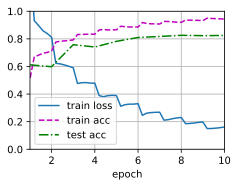

In [18]:
batch_size,devices,net=256,d2l.try_all_gpus(),d2l.resnet18(10,3)

def init_weights(m):
    if type(m) in [nn.Linear,nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs,test_augs,net,lr=0.001):
    train_iter=load_cifar10(True,train_augs,batch_size)
    test_iter=load_cifar10(False,test_augs,batch_size)
    loss=nn.CrossEntropyLoss(reduction="none")
    trainer=torch.optim.Adam(net.parameters(),lr=lr)
    train_ch13(net,train_iter,test_iter,loss,trainer,10,devices)

train_with_data_aug(train_augs,test_augs,net)

Exercises

与不使用图像增广进行对比

loss 0.065, train acc 0.977, test acc 0.817
2040.9 examples/sec on [device(type='cuda', index=0)]


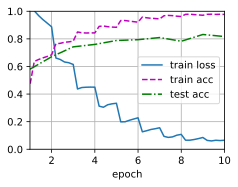

In [16]:
no_aug=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

net.apply(init_weights)
train_with_data_aug(no_aug,no_aug,net)

结合多种图像增广方法

loss 0.364, train acc 0.874, test acc 0.840
2030.8 examples/sec on [device(type='cuda', index=0)]


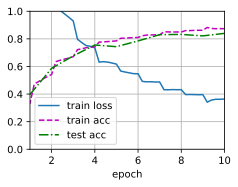

In [19]:
more_augs=torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomResizedCrop((32,32),scale=(0.8,1),ratio=(0.8,1.2)),
    torchvision.transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0),
    torchvision.transforms.ToTensor()
])

net.apply(init_weights)
train_with_data_aug(more_augs,test_augs,net)

使用AutoAugment在CIFAR-10数据集上进行自动图像增广

loss 0.326, train acc 0.887, test acc 0.849
2038.8 examples/sec on [device(type='cuda', index=0)]


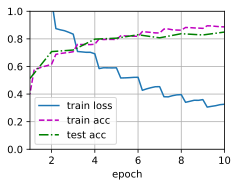

In [20]:
auto_augs=torchvision.transforms.Compose([
    torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.CIFAR10),
    torchvision.transforms.ToTensor()
])

net.apply(init_weights)
train_with_data_aug(auto_augs,test_augs,net)

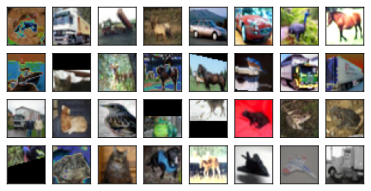

In [21]:
auto_aug=torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.CIFAR10)
d2l.show_images([auto_aug(all_images[i][0]) for i in range(32)],4,8,scale=0.8);

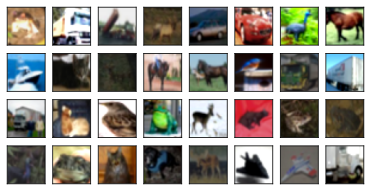

In [22]:
my_aug=torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomResizedCrop((32,32),scale=(0.8,1),ratio=(0.8,1.2)),
    torchvision.transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0)
])
d2l.show_images([my_aug(all_images[i][0]) for i in range(32)],4,8,scale=0.8);